In [1]:
!nvidia-smi

Sun Aug 21 21:29:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     3W /  N/A |      5MiB /  3911MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Requirements

In [2]:
%%script false --no- raise -error
!pip3 install jupyter==1.0.0
!pip3 install numpy==1.23.1
!pip3 install pandas==1.4.3
!pip3 install pytorch-lightning==1.7.0
!pip3 install scikit-learn==1.1.1
!pip3 install scipy==1.8.1
!pip3 install seaborn==0.11.2
!pip3 install sklearn==0.0
!pip3 install tensorboard==2.9.1
!pip3 install tqdm==4.64.0
!pip3 install torchinfo==1.7.0
!pip3 install opencv-contrib-python==4.6.0.66
!pip3 install scikit_image=0.19.3
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

# Import statements

In [49]:
import argparse
import os
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.functional import F
import pytorch_lightning as pl
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchinfo import summary
import cv2
import math

In [4]:
%matplotlib inline

# Configuration

In [42]:
config = dict(
    # Path directory for dataset
    dataset_path="datasets/pokemon/sprites/pokemon",
    # Path fo model checkpoint
    checkpoint_path=".pytorch/pokemon_dcgan/",
    # Number of workers for dataloader
    num_workers=8,
    # Batch size during training
    batch_size=128,
    # Spatial size of training images. All images will be resized to this
    #   size using a transformer.
    image_size=64,
    # Number of channels in the training images. For color images this is 3
    num_channel=3,
    # Size of z latent vector (i.e. size of generator input)
    z_size=100,
    # Size of feature maps in generator
    generator_hidden_size=64,
    # Generator network dimensions
    gen_dims=(8, 4, 2, 1),
    # Discriminator network dimensions
    dis_dims=(1, 2, 4, 8),
    # Size of feature maps in discriminator
    discriminator_hidden_size=64,
    # Number of training epochs
    num_epochs=5,
    # Learning rate for optimizers
    lr=0.0002,
    # Beta1 hyperparam for Adam optimizers
    beta1=0.5,
    beta2=0.999,
    # Number of GPUs available. Use 0 for CPU mode.
    ngpu=1,
    seed=42
)

device = torch.device("cuda:0" if (torch.cuda.is_available() and config['ngpu'] > 0) else "cpu")


# Prepare Dataset

In [6]:
%%script false --no- raise -error
!git clone https://github.com/PokeAPI/sprites.git datasets/pokemon/
!mkdir -p {config['dataset_path']}/0
!mv {config['dataset_path']}/*.png {config['dataset_path']}/0


In [56]:
# New Dataset instance based on official artwork
def transparent_white_bg_loader(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img.shape[-1] == 4:
        alpha_channel = img[:, :, 3].astype(np.uint8)
        _, mask = cv2.threshold(alpha_channel, 254, 255, cv2.THRESH_BINARY)  # binarize mask
        color = img[:, :, :3].astype(np.uint8)
        color = cv2.bitwise_not(color, mask=mask)
        new_img = cv2.bitwise_not(color)
        return new_img
    elif len(img.shape) == 2:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return  img.astype(np.uint8)

def is_valid(path):
    return 'png' in path

dataset = dset.ImageFolder(
    root=Path(config['dataset_path']),
    loader=transparent_white_bg_loader,
    transform=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(config['image_size']),
        transforms.CenterCrop(config['image_size']),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        ),
    ]),
    is_valid_file=is_valid
)
ds_length = len(dataset)
train_ds, val_ds = random_split(
    dataset,
    [math.floor(ds_length*0.8), math.ceil(ds_length*0.2)],
)

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds,
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    drop_last=True
)

## Visualize Dataset

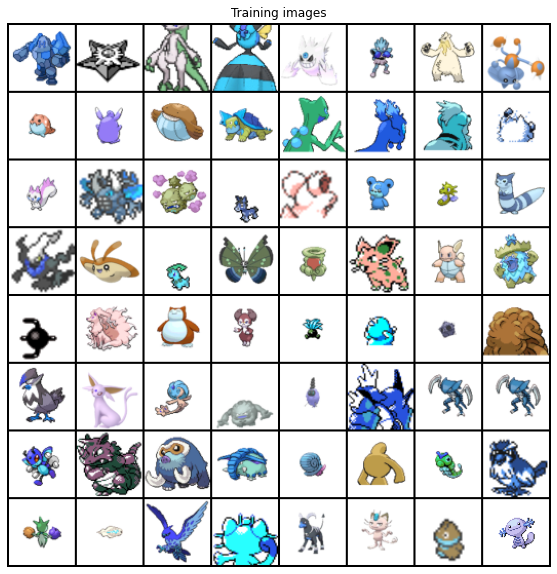

In [51]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training images")
plt.imshow(
    vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).permute([1, 2, 0]).cpu()
)
plt.show()

# Model

## Helper functions

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Network

In [10]:

class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, num_channel, gen_dims, negative_slope=0.2, kernel_size=4):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_channel = num_channel
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.features = self._make_layers(gen_dims, negative_slope)

    def _make_layers(self, gen_dims, negative_slope):
        layers = []
        in_channels = self.input_size
        for i, layer in enumerate(gen_dims):
            layers += [
                nn.ConvTranspose2d(
                    in_channels,
                    self.hidden_dim*layer,
                    self.kernel_size,
                    bias=False,
                    stride=1 if i==0 else 2,
                    padding=0 if i==0 else 1,
                ),
                nn.BatchNorm2d(self.hidden_dim*layer),
                nn.LeakyReLU(negative_slope=negative_slope),
            ]
            in_channels = self.hidden_dim*layer
        layers += [
            nn.ConvTranspose2d(
                in_channels,
                self.num_channel,
                self.kernel_size,
                bias=False,
                stride=2,
                padding=1,
            ),
            nn.Tanh()
        ]
        return nn.Sequential(*layers)

    def forward(self, input):
        return self.features(input)


In [11]:
# Instantiate the generator
G = Generator(
    config['z_size'],
    config['generator_hidden_size'],
    config['num_channel'],
    config['gen_dims'],
).to(device)

# Random weights initialization
#  to mean=0, stdev=0.02
G.apply(weights_init)

# Print the model
print(G)

Generator(
  (features): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), pad

In [12]:
summary(G, (1, config['z_size'], 1, 1), col_names=["input_size", "output_size", "kernel_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Generator                                [1, 100, 1, 1]            [1, 3, 64, 64]            4                         --
├─Sequential: 1-1                        [1, 100, 1, 1]            [1, 3, 64, 64]            --                        --
│    └─ConvTranspose2d: 2-1              [1, 100, 1, 1]            [1, 512, 4, 4]            [4, 4]                    819,200
│    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            [1, 512, 4, 4]            --                        1,024
│    └─LeakyReLU: 2-3                    [1, 512, 4, 4]            [1, 512, 4, 4]            --                        --
│    └─ConvTranspose2d: 2-4              [1, 512, 4, 4]            [1, 256, 8, 8]            [4, 4]                    2,097,152
│    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            [1, 256, 8, 8]            --                        512
│  

## Discriminator Network

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, num_channel, dis_dims, negative_slope=0.2, kernel_size=4):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_channel = num_channel
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.features = self._make_layers(dis_dims, negative_slope)

    def _make_layers(self, dis_dims, negative_slope):
        layers = []
        in_channels = self.input_size
        for i, layer in enumerate(dis_dims):
            layers += [
                nn.Conv2d(
                    in_channels,
                    self.hidden_dim*layer,
                    self.kernel_size,
                    bias=False,
                    stride=2,
                    padding=1,
                ),
                nn.BatchNorm2d(self.hidden_dim*layer),
                nn.LeakyReLU(negative_slope=negative_slope),
            ]
            in_channels = self.hidden_dim*layer
        layers += [
            nn.Conv2d(
                in_channels,
                self.num_channel,
                self.kernel_size,
                bias=False,
                stride=1,
                padding=0,
            ),
            nn.Sigmoid()
        ]
        return nn.Sequential(*layers)

    def forward(self, input):
        return self.features(input)

In [14]:
# Instantiate the discriminator
D = Discriminator(
    config['num_channel'],
    config['discriminator_hidden_size'],
    1,
    config['dis_dims'],
).to(device)

# Random weights initialization
#  to mean=0, stdev=0.02
D.apply(weights_init)

# Print the model
print(D)

Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Sigmoid(

In [15]:
summary(D, (1, config['num_channel'], config['image_size'], config['image_size']),
        col_names=["input_size", "output_size", "kernel_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Kernel Shape              Param #
Discriminator                            [1, 3, 64, 64]            [1, 1, 1, 1]              4                         --
├─Sequential: 1-1                        [1, 3, 64, 64]            [1, 1, 1, 1]              --                        --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            [1, 64, 32, 32]           [4, 4]                    3,072
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           [1, 64, 32, 32]           --                        128
│    └─LeakyReLU: 2-3                    [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           [1, 128, 16, 16]          [4, 4]                    131,072
│    └─BatchNorm2d: 2-5                  [1, 128, 16, 16]          [1, 128, 16, 16]          --                        256
│    └─Le

## DCGAN

In [54]:
class DCGAN(pl.LightningModule):
    def __init__(
            self,
            batch_size=128,
            image_size=64,
            num_channel=3,
            z_size=100,
            generator_hidden_size=64,
            gen_dims=(8, 4, 2, 1),
            dis_dims=(1, 2, 4, 8),
            discriminator_hidden_size=64,
            lr=0.0002,
            beta1=0.5,
            beta2=0.999,
            **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        self.G = Generator(
            z_size,
            generator_hidden_size,
            num_channel,
            gen_dims,
        )
        G.apply(weights_init)
        self.D = Discriminator(
            num_channel,
            discriminator_hidden_size,
            1,
            dis_dims,
        )
        D.apply(weights_init)

        self.validation_z = torch.empty(
            1,
            z_size,
            1,
            1,
            device=device
        ).uniform_(-1, 1)

    def forward(self, z):
        return self.G(z)

    def loss_function(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, _ = batch

        # input noise
        z = torch.empty(
            self.hparams.batch_size,
            self.hparams.z_size,
            1,
            1,
            device=device
        ).uniform_(-1, 1)

        # ground truth with label smoothing
        labels = torch.full((self.hparams.batch_size,), 0.9, device=device)

        # train generator
        if optimizer_idx==0:
            self.generated_images = self(z)

            # calculate loss for generator
            g_loss = self.loss_function(self.D(self.generated_images).view(-1), labels)
            self.log('g_loss', g_loss, prog_bar=True)
            return g_loss

        # train discriminator
        elif optimizer_idx==1:
            real_loss = self.loss_function(self.D(images).view(-1), labels)

            labels = torch.full((self.hparams.batch_size,), 0., device=device)
            fake_loss = self.loss_function(self.D(self(z).detach()).view(-1), labels)

            # discriminator loss is the sum loss of fake and real samples
            d_loss =  fake_loss + real_loss
            self.log('d_loss', d_loss, prog_bar=True)
            return d_loss

    def configure_optimizers(self):
        g_opt = torch.optim.Adam(
            self.G.parameters(),
            lr=self.hparams.lr,
            betas=(self.hparams.beta1, self.hparams.beta2)
        )

        d_opt = torch.optim.Adam(
            self.D.parameters(),
            lr=self.hparams.lr,
            betas=(self.hparams.beta1, self.hparams.beta2)
        )

        return [g_opt, d_opt], []

    def validation_step(self, *args, **kwargs):
        # log sampled images
        sample_imgs = self(self.validation_z)
        grid = vutils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)


# Training

## Checkpoint callback

In [17]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='checkpoint',
    filename='pokemon_dcgan-{g_loss:.2f}-{d_loss:.2}',
    save_top_k=1,
    monitor='g_loss',
    save_last=False,
)

## Trainer

In [57]:
dccgan = DCGAN(
    batch_size=config['batch_size'],
    image_size=config['image_size'],
    num_channel=config['num_channel'],
    z_size=config['z_size'],
    generator_hidden_size=config['generator_hidden_size'],
    gen_dims=config['gen_dims'],
    dis_dims=config['dis_dims'],
    discriminator_hidden_size=config['discriminator_hidden_size'],
    lr=config['lr'],
    beta1=config['beta1'],
    beta2=config['beta2'],
)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=config['num_epochs'],
    callbacks=[checkpoint_callback],
)
trainer.fit(dccgan, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params
---------------------------------------
0 | G    | Generator     | 3.6 M 
1 | D    | Discriminator | 2.8 M 
---------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.370    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]